# Advanced Lane Finding

## Udacity Self Driving Car Engineer Nanodegree - Project 4

The goal of this project is to develop a pipeline to process a video stream from a forward-facing camera mounted on the front of a car, and output an annotated video which identifies:
- The positions of the lane lines 
- The location of the vehicle relative to the center of the lane
- The radius of curvature of the road

In [1]:
%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque


### Step 1: Distortion Correction

The first step in the project is to remove any distortion from the images by calculating the camera calibration matrix and distortion coefficients using a series of images of a chessboard.

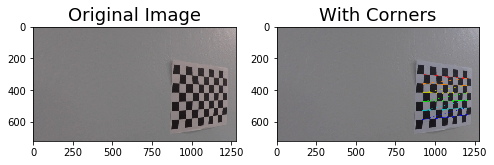

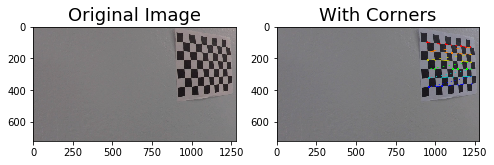

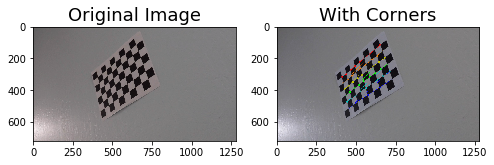

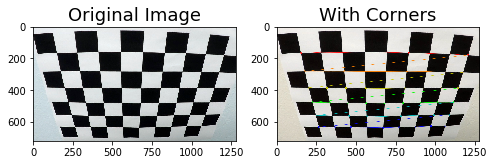

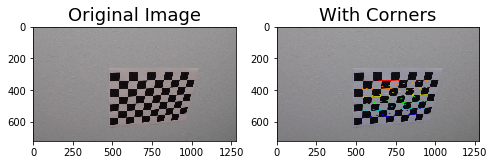

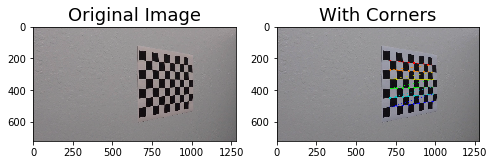

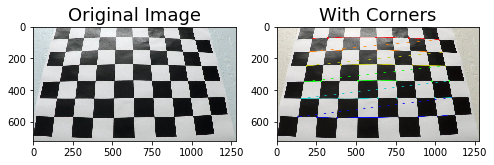

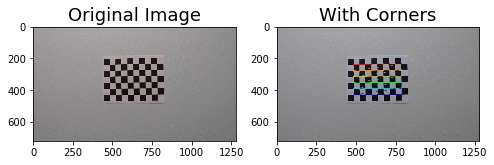

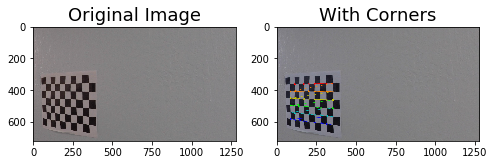

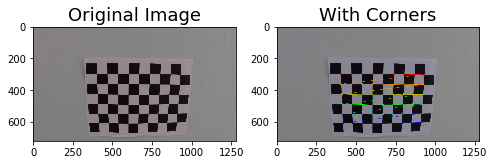

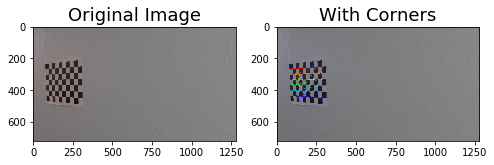

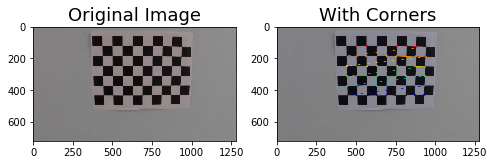

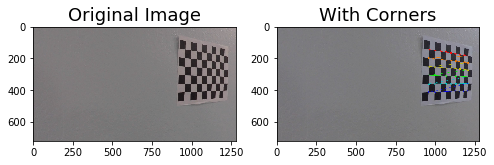

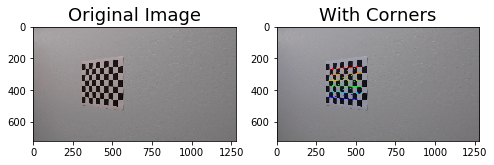

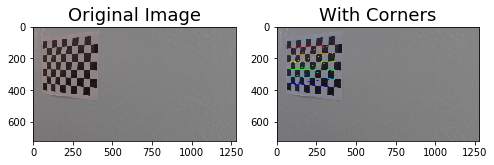

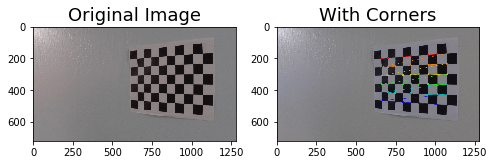

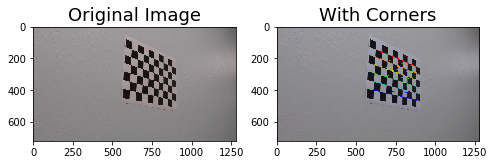

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)

Next I will define a function `undistort()` which uses the calculate camera calibration matrix and distortion coefficients to remove distortion from an image and output the undistorted image.

In [3]:
# Remove distortion from images
def undistort(image, show=True, read = True):
    if read:
        img = cv2.imread(image)
    else:
        img = image
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    else:
        return undist

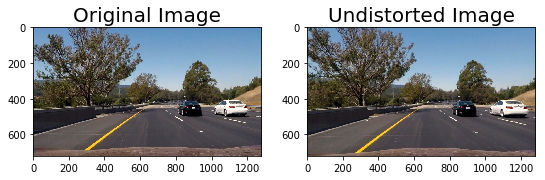

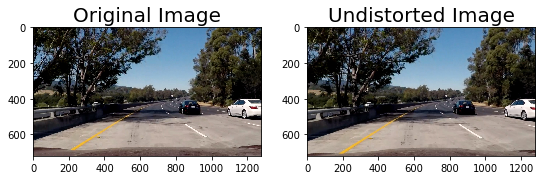

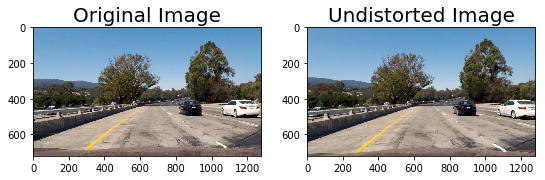

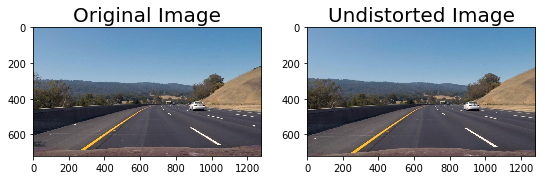

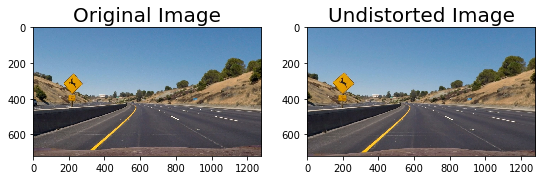

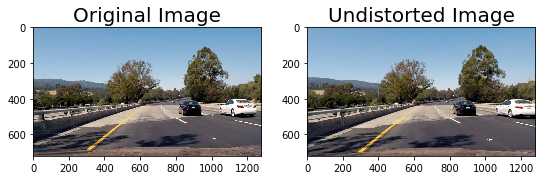

In [4]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    undistort(image)

### Step 2: Perspective Transform

In this step I will define a function `birds_eye()` which transforms the undistorted image to a "birds eye view" of the road which focuses only on the lane lines and displays them in such a way that they appear to be relatively parallel to eachother. This will make it easier later on to fit polynomials to the lane lines and measure the curvature.

In [5]:
# Perform perspective transform
def birds_eye(img, display=True, read = True):
    if read:
        undist = undistort(img, show = False)
    else:
        undist = undistort(img, show = False, read=False) 
    img_size = (undist.shape[1], undist.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped, M

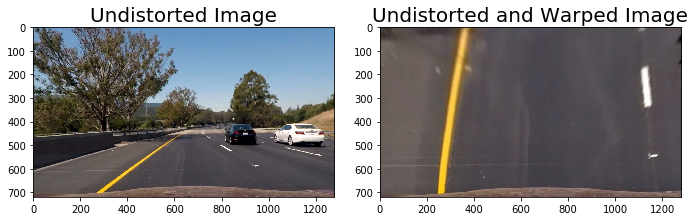

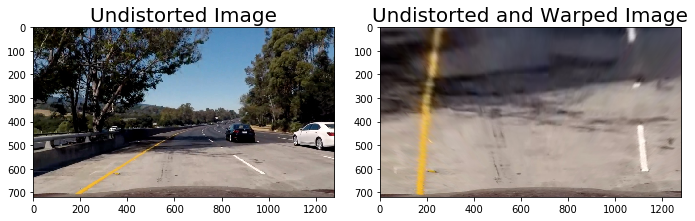

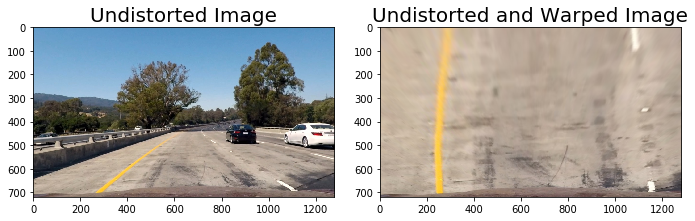

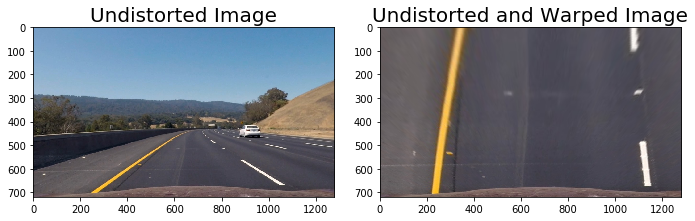

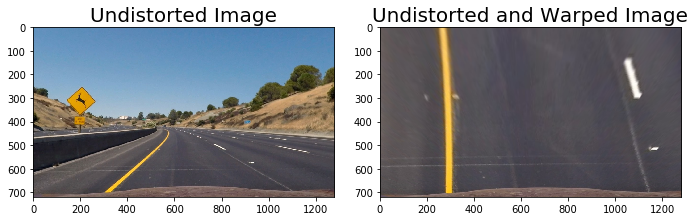

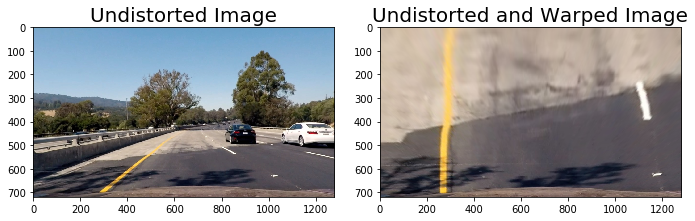

In [6]:
for image in glob.glob('test_images/test*.jpg'):
    birds_eye(image)

### Step 3: Apply Binary Thresholds

In this step I attempted to convert the warped image to different color spaces and create binary thresholded images which highlight only the lane lines and ignore everything else. 
I found that the following color channels and thresholds did a good job of identifying the lane lines in the provided test images:
- The S Channel from the HLS color space, with a min threshold of 180 and a max threshold of 255, did a fairly good job of identifying both the white and yellow lane lines, but did not pick up 100% of the pixels in either one, and had a tendency to get distracted by shadows on the road.
- The L Channel from the LUV color space, with a min threshold of 225 and a max threshold of 255, did an almost perfect job of picking up the white lane lines, but completely ignored the yellow lines.
- The B channel from the Lab color space, with a min threshold of 155 and an upper threshold of 200, did a better job than the S channel in identifying the yellow lines, but completely ignored the white lines. 

I chose to create a combined binary threshold based on the three above mentioned binary thresholds, to create one combination thresholded image which does a great job of highlighting almost all of the white and yellow lane lines.

**Note: The S binary threshold was left out of the final combined binary image and was not used in detecting lane lines because it added extra noise to the binary image and interfered with detecting lane lines accurately.**

In [7]:
# Create binary thresholded images to isolate lane line pixels
def apply_thresholds(image, show=True , read=True):
    if read :
        img, M = birds_eye(image, display = False)
    else:
        img, M = birds_eye(image, display = False , read = False)

    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    if show == True:
        # Plotting thresholded images
        f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        ax1.set_title('Original Image', fontsize=16)
        ax1.imshow(cv2.cvtColor(undistort(image, show=False),cv2.COLOR_BGR2RGB))
        
        ax2.set_title('Warped Image', fontsize=16)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax3.set_title('s binary threshold', fontsize=16)
        ax3.imshow(s_binary, cmap='gray')
        
        ax4.set_title('b binary threshold', fontsize=16)
        ax4.imshow(b_binary, cmap='gray')
        
        ax5.set_title('l binary threshold', fontsize=16)
        ax5.imshow(l_binary, cmap='gray')

        ax6.set_title('Combined color thresholds', fontsize=16)
        ax6.imshow(combined_binary, cmap='gray')
        
        
    else: 
        return combined_binary

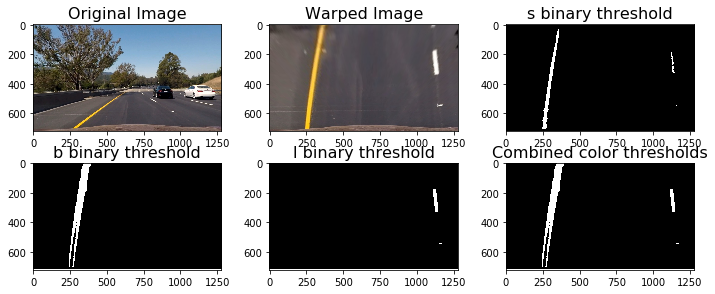

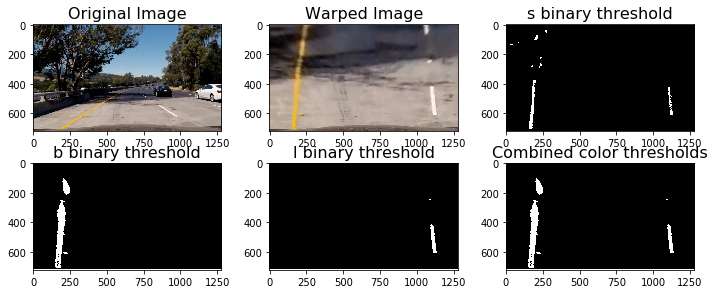

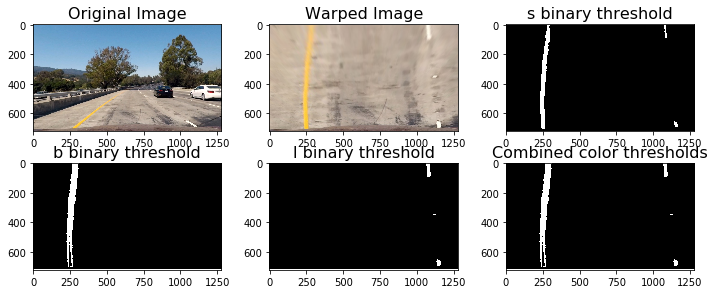

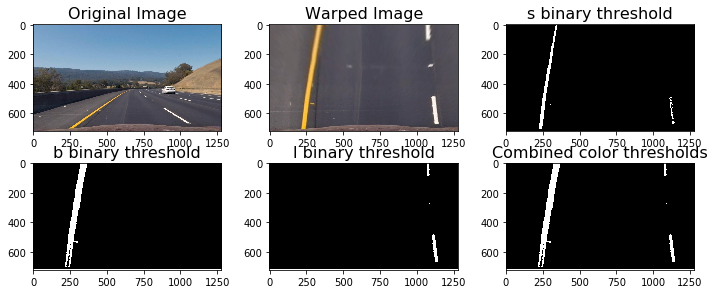

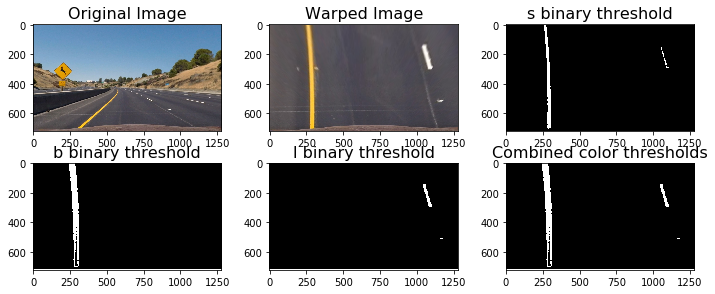

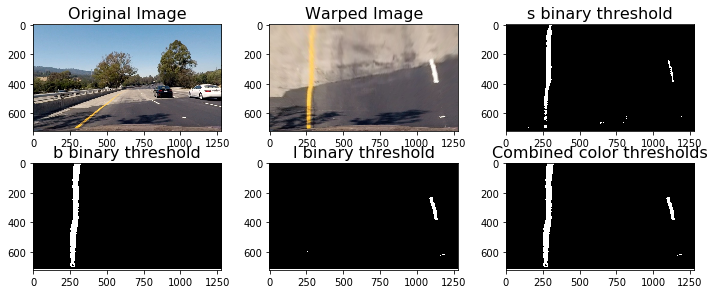

In [8]:
for image in glob.glob('test_images/test*.jpg'):
    apply_thresholds(image)

In [9]:
# Define the complete image processing pipeline, reads raw image and returns binary image with lane lines identified
# (hopefully)
def pipeline(img , show=False , read=True):
    return apply_thresholds(img , show , read)

### Sliding Window Polyfit

In [10]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Print histogram from sliding window polyfit for example image
    plt.plot(histogram)
    plt.xlim(0, 1280)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    #print(midpoint)
    quarter_point = np.int(midpoint//2)
    #print(quarter_point)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

(720, 0)

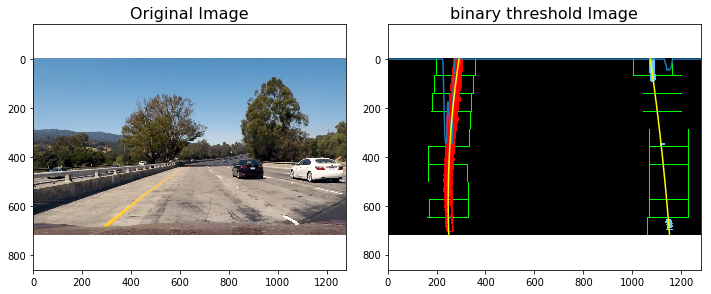

In [11]:
# visualize the result on example image
#exampleImg = cv2.imread('./test_images/test2.jpg')
exampleImg='test_images/test1.jpg'
#exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin = apply_thresholds(exampleImg , show=False )

exampleImg = cv2.imread('test_images/test1.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)


        
f, (ax1, ax2) = plt.subplots(1, 2, sharey='col', sharex='row', figsize=(10,4))
f.tight_layout()
        
ax1.set_title('Original Image', fontsize=16)
ax1.imshow(exampleImg)

ax2.set_title('binary threshold Image', fontsize=16)
ax2.imshow(exampleImg_bin , 'gray')

left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

h = exampleImg.shape[0]
#print(left_fit)
#print(right_fit)
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
#print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

...


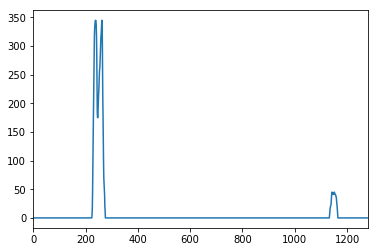

In [12]:
# Print histogram from sliding window polyfit for example image
plt.plot(histogram)
plt.xlim(0, 1280)
print('...')

In [13]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

(720, 0)

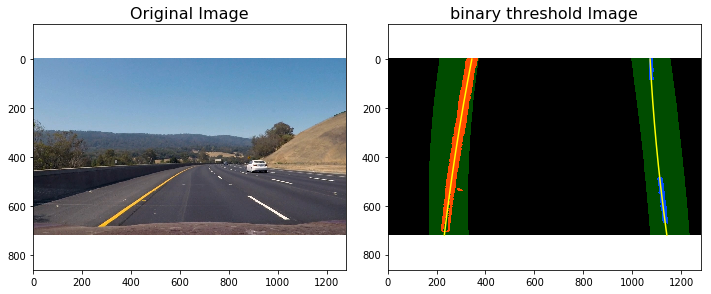

In [14]:
# visualize the result on example image
exampleImg2 = cv2.imread('test_images/test3.jpg')
exampleImg2 = cv2.cvtColor(exampleImg2, cv2.COLOR_BGR2RGB)
exampleImg2_bin = pipeline('test_images/test3.jpg')   
margin = 80
 
f, (ax1, ax2) = plt.subplots(1, 2, sharey='col', sharex='row', figsize=(10,4))
f.tight_layout()
        
ax1.set_title('Original Image', fontsize=16)
ax1.imshow(exampleImg2)

ax2.set_title('binary threshold Image', fontsize=16)
ax2.imshow(exampleImg2_bin , 'gray')

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Radius of Curvature and Distance from Lane Center Calculation



In [15]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 12/720 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/900 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        #print( l_fit, r_fit,l_fit_x_int,r_fit_x_int,car_position)
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

In [16]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg2_bin, left_fit2, right_fit2, left_lane_inds2, right_lane_inds2)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 633.377580267 m, 558.010508577 m
Distance from lane center for example: -0.192041637105 m


### Draw the Detected Lane Back onto the Original Image

In [17]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
   
    return result

19.0243316694 18.5146466019 -0.251548407837


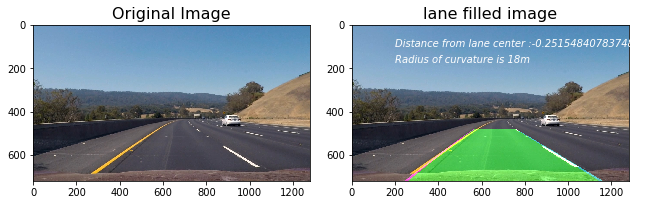

In [18]:
src = np.float32([[490, 482],[810, 482],
                  [1250, 720],[40, 720]])
dst = np.float32([[0, 0], [1280, 0], 
                 [1250, 720],[40, 720]])
Minv = cv2.getPerspectiveTransform(dst, src)
exampleImg2_out1 = draw_lane(exampleImg2, exampleImg2_bin, left_fit, right_fit, Minv)

rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg2_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)
print(rad_l, rad_r, d_center)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
f.tight_layout()
       
ax1.set_title('Original Image', fontsize=16)
ax1.imshow(exampleImg2)

ax2.set_title('lane filled image', fontsize=16)
ax2.imshow(exampleImg2_out1 , 'gray')


ax2.text(200, 100, 'Distance from lane center :{} m'.format(d_center),
         style='italic', color='white', fontsize=10)
ax2.text(200, 175, 'Radius of curvature is {}m'.format(int((rad_l + rad_r)/2)),
     style='italic', color='white', fontsize=10)


### Draw Curvature Radius and Distance from Center Data onto the Original Image

In [19]:
def fill_lane(image , display= True , read=True):
    
    # visualize the result on example image
    if read :
        exampleImg = cv2.imread(image)
        exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
        exampleImg_bin = pipeline(image , show=False , read=True) 
        left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

    else:
        exampleImg = image
        exampleImg = cv2.cvtColor(exampleImg ,cv2.COLOR_BGR2RGB)
        exampleImg_bin = pipeline(exampleImg , show=False , read=False) 
        exampleImg = image
        global left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data
        left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)
        if left_fit is None or right_fit is None:
            print(left_fit, right_fit, left_lane_inds, right_lane_inds)
            plt.imshow(exampleImg )
            return image
    margin = 20

    
    #h = exampleImg.shape[0]
    #print(exampleImg.shape)
    #print(exampleImg_bin)
    #print(left_fit, right_fit, left_lane_inds, right_lane_inds)
    h = exampleImg.shape[0]
    w = exampleImg.shape[1]
    
  
    # Create an output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
    window_img = np.zeros_like(out_img)
    warp_zero = np.zeros_like(exampleImg_bin).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



    nonzero = exampleImg_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
    

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    
    src = np.float32([[490, 482],[810, 482],
                  [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    exampleImg_out1 = cv2.addWeighted(exampleImg, 1, newwarp, 0.5, 0)
   
   

    #exampleImg_out1 = draw_lane(exampleImg, exampleImg_bin, left_fitx, right_fitx, Minv)

    rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)
    #print(rad_l, rad_r, d_center)
    if display == True:
          #print( left_fit, right_fit, left_lane_inds, right_lane_inds)
        rectangles = visualization_data[0]
        histogram = visualization_data[1]


        f, (ax1, ax2 ,ax3) = plt.subplots(1,3, figsize=(9, 6))
        f.tight_layout()

        ax1.set_title('Original Image', fontsize=16)
        ax1.imshow(exampleImg)

        ax2.set_title('lane filled image', fontsize=16)
        ax2.imshow(exampleImg_out1 , 'gray')


        ax2.text(200, 100, 'Distance from lane center :{} m'.format(d_center),
                 style='italic', color='white', fontsize=10)
        ax2.text(200, 175, 'Radius of curvature is {}m'.format(int((rad_l + rad_r)/2)),
             style='italic', color='white', fontsize=10)

        ax3.set_title('binary poly fit', fontsize=16)
        ax3.imshow(window_img , 'gray')
        ax3.plot(left_fitx, ploty, color='yellow')
        ax3.plot(right_fitx, ploty, color='yellow')
    else:
        #print( rad_l, rad_r, d_center )
        str1='Distance from lane center :{} m'.format(d_center)
        str2='Radius of curvature is {}m'.format(int((rad_l + rad_r)/2))
        texted_image1 =cv2.putText(img=np.copy(exampleImg_out1), text=str1, org=(0,50),fontFace=3, fontScale=1, color=(0,0,255), thickness=2)
        texted_image2 =cv2.putText(img=np.copy(texted_image1), text=str2, org=(0,120),fontFace=3, fontScale=1, color=(0,0,255), thickness=2)
        return texted_image2



### Step 7: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

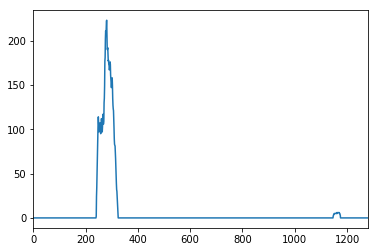

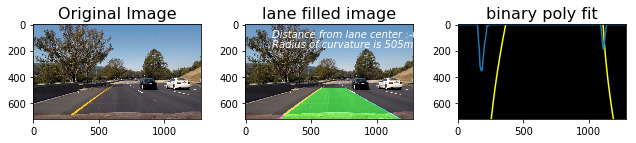

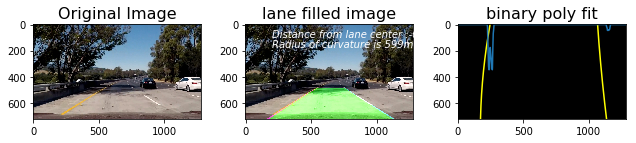

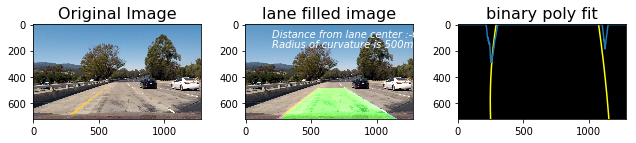

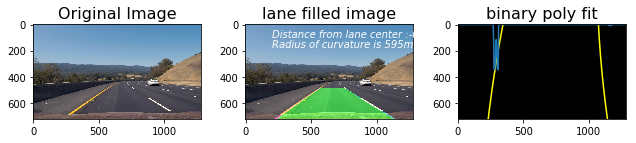

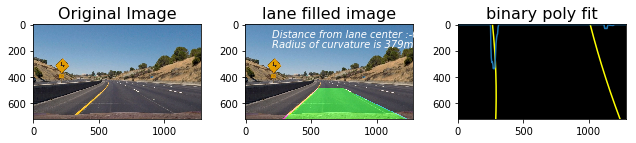

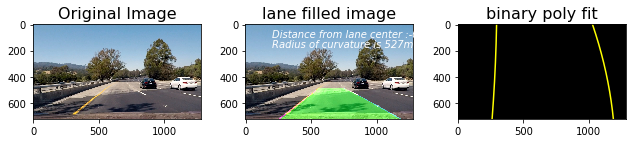

In [20]:
for image in glob.glob('test_images/test*.jpg'):
    fill_lane(image)

## Video Processing Pipeline:



In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
def process_video_image(image):
    return fill_lane(image , display= False , read=False)

## write images from video to analyse 

In [23]:
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(10,20)#.subclip(22,26)
#video_input1.to_images_sequence("tmp_images/images%03d.jpeg")



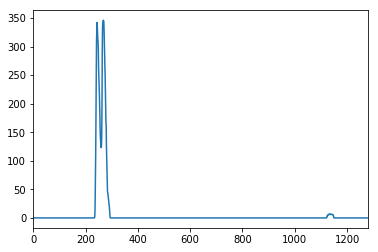

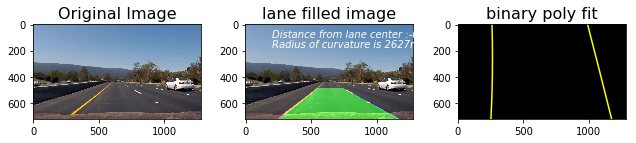

In [24]:
for image in glob.glob('tmp_images/images*.jpeg'):
    fill_lane(image)
    break

In [ ]:
#process_video_image('tmp_images/images000.jpeg')
video_input1.fl_image(process_video_image).to_images_sequence("tmp_output_images/images%03d.jpeg")

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 83%|████████▎ | 1049/1261 [13:49<03:08,  1.13it/s]

[  1.88205471e-04  -2.20364852e-01   2.44740016e+02] None [26508 26509 26510 ...,  4597  4598  4599] []



 83%|████████▎ | 1050/1261 [13:49<02:59,  1.17it/s]

[  1.88312960e-04  -2.26679003e-01   2.38380726e+02] None [29541 29542 29543 ...,  4452  4453  4454] []



100%|█████████▉| 1260/1261 [16:44<00:00,  1.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 44min 41s, sys: 3min 21s, total: 48min 3s
Wall time: 16min 44s


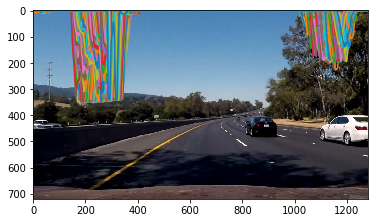

In [56]:


video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)#.subclip(22,26)
processed_video = video_input1.fl_image(process_video_image)
%time processed_video.write_videofile(video_output1, audio=False)

* The following is the result of the video pipeline being run on the project video.

In [58]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_video_output.mp4'))

[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4



  1%|▏         | 7/485 [00:06<06:37,  1.20it/s]

[  2.27403225e-04  -5.25880819e-01   5.52514133e+02] None [7099 7100 7101 ...,   65   66   67] []



  2%|▏         | 8/485 [00:06<06:21,  1.25it/s]

[  8.85417393e-05  -4.02807275e-01   5.27216603e+02] None [6704 6705 6706 ...,  306  307  308] []



  2%|▏         | 9/485 [00:07<06:15,  1.27it/s]

[  9.86871146e-05  -4.12193805e-01   5.31103160e+02] None [6738 6739 6740 ...,  409  410  411] []



  2%|▏         | 10/485 [00:08<06:12,  1.28it/s]

[  6.63231604e-05  -3.78432564e-01   5.23286081e+02] None [6454 6455 6456 ...,  322  323  324] []



  2%|▏         | 11/485 [00:09<06:06,  1.29it/s]

[  5.19726820e-05  -3.59864216e-01   5.15624129e+02] None [6431 6432 6433 ...,  285  286  287] []



  2%|▏         | 12/485 [00:10<07:46,  1.01it/s]

[  3.85201629e-05  -3.36698739e-01   5.05498981e+02] None [6436 6437 6438 ...,  251  252  253] []



  3%|▎         | 13/485 [00:11<07:18,  1.08it/s]

[  4.70201324e-05  -3.47263007e-01   5.07093458e+02] None [6636 6637 6638 ...,  115  116  117] []



  3%|▎         | 14/485 [00:12<06:56,  1.13it/s]

[  4.39741246e-05  -3.40157035e-01   5.03456925e+02] None [6493 6494 6495 ...,   29   30   31] []



  3%|▎         | 15/485 [00:12<06:36,  1.18it/s]

[  4.44934643e-05  -3.38818282e-01   5.01431601e+02] None [6436 6437 6438 ...,    2    3    4] []



  3%|▎         | 16/485 [00:14<08:09,  1.04s/it]

[  4.60456900e-05  -3.37701842e-01   4.99097100e+02] None [6531 6532 6533 ...,  632  633  634] []



  4%|▎         | 17/485 [00:15<07:22,  1.06it/s]

[  5.78781980e-05  -3.45540807e-01   4.98543082e+02] None [6296 6297 6298 ...,    0    1    2] []



  4%|▎         | 18/485 [00:15<06:52,  1.13it/s]

[  1.46107673e-05  -3.03097762e-01   4.89370500e+02] None [6394 6395 6396 ...,  650  651  652] []



  4%|▍         | 19/485 [00:16<06:38,  1.17it/s]

[  1.35034502e-05  -2.95996166e-01   4.83353374e+02] None [6589 6590 6591 ...,   71   72   73] []



  4%|▍         | 20/485 [00:17<06:26,  1.20it/s]

[ -2.25823666e-05  -2.57425335e-01   4.73163931e+02] None [6567 6568 6569 ...,   26   27   28] []



  4%|▍         | 21/485 [00:18<06:13,  1.24it/s]

[  3.66031591e-06  -2.79958072e-01   4.75561766e+02] None [6756 6757 6758 ...,   28   29   30] []



  5%|▌         | 26/485 [00:22<06:09,  1.24it/s]

[  8.19054547e-05  -3.70017644e-01   5.02965541e+02] None [7083 7084 7085 ...,  121  122  123] []



  6%|▌         | 27/485 [00:23<05:53,  1.30it/s]

[  7.74213411e-05  -3.64950457e-01   4.99568502e+02] None [7532 7533 7534 ...,  276  277  278] []



  6%|▌         | 28/485 [00:24<05:53,  1.29it/s]

[  7.27801421e-05  -3.66287982e-01   5.03778350e+02] None [7224 7225 7226 ...,  107  108    0] []



  7%|▋         | 35/485 [00:29<05:46,  1.30it/s]

[  6.14671592e-05  -3.27795664e-01   4.81959096e+02] None [6535 6536 6537 ...,  607    0    1] []



  8%|▊         | 37/485 [00:31<07:20,  1.02it/s]

[ -1.01297270e-04  -1.69332398e-01   4.46557480e+02] None [6548 6549 6550 ...,   37   38   39] []



 13%|█▎        | 64/485 [00:52<05:35,  1.26it/s]

[  2.87471756e-04  -6.45465113e-01   5.59656831e+02] None [3347 3348 3349 ...,   28   29   30] []



 13%|█▎        | 65/485 [00:52<05:25,  1.29it/s]

[  2.02240637e-04  -5.65959554e-01   5.43234227e+02] None [4013 4014 4015 ...,  119  120  121] []



 14%|█▎        | 66/485 [00:53<05:19,  1.31it/s]

[  1.64369630e-04  -5.35553345e-01   5.40631387e+02] None [3948 3949 3950 ...,    0    1    2] []



 19%|█▉        | 92/485 [01:14<05:47,  1.13it/s]

[  2.16939685e-04  -6.14485187e-01   5.91906063e+02] None [2452 2453 2454 ...,  307  308  309] []



 22%|██▏       | 106/485 [01:25<04:49,  1.31it/s]

[  3.25445441e-06  -3.11311247e-01   5.08807333e+02] None [4006 4007 4008 ...,  528  529  530] []



 28%|██▊       | 134/485 [01:48<04:50,  1.21it/s]

None None [] []



 28%|██▊       | 135/485 [01:49<04:38,  1.26it/s]

None None [] []



 28%|██▊       | 136/485 [01:49<04:29,  1.30it/s]

None None [] []



 28%|██▊       | 137/485 [01:50<04:26,  1.31it/s]

None None [] []



 28%|██▊       | 138/485 [01:51<04:21,  1.33it/s]

None None [] []



 29%|██▊       | 139/485 [01:52<04:44,  1.22it/s]

None None [] []



 29%|██▉       | 140/485 [01:53<05:28,  1.05it/s]

None None [] []



 29%|██▉       | 141/485 [01:54<05:02,  1.14it/s]

None None [] []



 29%|██▉       | 142/485 [01:54<04:48,  1.19it/s]

None None [] []



 29%|██▉       | 143/485 [01:55<04:39,  1.22it/s]

None None [] []



 30%|██▉       | 144/485 [01:56<04:38,  1.22it/s]

None None [] []



 30%|██▉       | 145/485 [01:57<04:29,  1.26it/s]

None None [] []



 30%|███       | 146/485 [01:58<04:46,  1.18it/s]

None None [] []



 30%|███       | 147/485 [01:59<05:24,  1.04it/s]

None None [] []



 31%|███       | 148/485 [02:00<06:07,  1.09s/it]

None None [] []



 31%|███       | 149/485 [02:02<06:20,  1.13s/it]

None [  7.28627874e-05  -2.68823015e-02   1.00976277e+03] [] [1835 1836 1837 ...,  657  658  659]



 42%|████▏     | 202/485 [02:48<04:21,  1.08it/s]

[ -7.92913745e-07  -3.13469689e-01   5.04509545e+02] None [4810 4811 4812 ...,   63   64   65] []



 45%|████▍     | 216/485 [03:00<03:48,  1.18it/s]

[  1.08702395e-04  -4.13865615e-01   5.18354982e+02] None [5498 5499 5500 ...,  501  502  503] []



 47%|████▋     | 230/485 [03:10<03:16,  1.30it/s]

[  9.66740931e-05  -4.17346829e-01   5.25668089e+02] None [4416 4417 4418 ...,   24   25   26] []



 48%|████▊     | 231/485 [03:11<03:14,  1.31it/s]

[  1.06877845e-04  -4.21562391e-01   5.22756168e+02] None [4963 4964 4965 ...,  172  173  174] []



 50%|█████     | 243/485 [03:20<03:22,  1.20it/s]

[  1.43616280e-04  -4.77483738e-01   5.43831201e+02] None [4920 4921 4922 ...,  749  750  751] []



 51%|█████     | 245/485 [03:22<03:06,  1.29it/s]

[  1.46920450e-04  -4.82130211e-01   5.43537394e+02] None [4960 4961 4962 ...,  182  183  184] []



 51%|█████     | 246/485 [03:23<02:59,  1.34it/s]

[  1.05923698e-04  -4.37585994e-01   5.31884015e+02] None [5216 5217 5218 ...,  364  365  366] []



 51%|█████     | 248/485 [03:25<03:25,  1.15it/s]

[  2.04536505e-05  -3.48703760e-01   5.13126141e+02] None [5197 5198 5199 ...,  421  422  423] []



 53%|█████▎    | 257/485 [03:32<02:51,  1.33it/s]

[  9.19779333e-05  -3.95928853e-01   5.16901122e+02] None [5163 5164 5165 ...,  135  136  137] []



 56%|█████▌    | 271/485 [03:42<02:36,  1.37it/s]

[  1.44503278e-04  -4.57928701e-01   5.31818518e+02] None [5508 5509 5510 ...,  257  258  259] []



 56%|█████▋    | 273/485 [03:44<02:47,  1.26it/s]

[  2.03361534e-04  -5.38452784e-01   5.59355984e+02] None [5347 5348 5349 ...,  254  255  256] []



 62%|██████▏   | 299/485 [04:04<02:16,  1.37it/s]

[  1.08366345e-04  -4.13439425e-01   5.15239700e+02] None [5061 5062 5063 ...,  468  469  470] []



 62%|██████▏   | 300/485 [04:04<02:19,  1.32it/s]

[  8.61916561e-05  -3.92136737e-01   5.09463104e+02] None [5540 5541 5542 ...,  663  664  665] []



 62%|██████▏   | 301/485 [04:05<02:18,  1.33it/s]

[  8.45370679e-05  -3.89749442e-01   5.07436736e+02] None [6200 6201 6202 ...,    4    5    6] []



 62%|██████▏   | 303/485 [04:07<02:22,  1.28it/s]

[  8.41197468e-05  -3.95823137e-01   5.09543925e+02] None [5517 5518 5519 ...,  334  335  336] []



 63%|██████▎   | 305/485 [04:08<02:13,  1.35it/s]

[  7.15466020e-05  -3.92031703e-01   5.15106455e+02] None [5807 5808 5809 ...,   25   26   27] []



 64%|██████▍   | 312/485 [04:14<02:18,  1.25it/s]

[  6.93658157e-05  -3.69751248e-01   5.05859254e+02] None [5837 5838 5839 ...,   89   90   91] []



 65%|██████▍   | 313/485 [04:15<02:19,  1.23it/s]

[  7.57168086e-05  -3.75297258e-01   5.04596605e+02] None [6569 6570 6571 ...,  289  290  291] []



 65%|██████▍   | 314/485 [04:15<02:16,  1.25it/s]

[  4.71675822e-05  -3.44069602e-01   4.95100130e+02] None [6720 6721 6722 ...,  124  125  126] []



 65%|██████▍   | 315/485 [04:16<02:14,  1.26it/s]

[  5.26645964e-05  -3.50852535e-01   4.96933135e+02] None [6664 6665 6666 ...,  139  140  141] []



 67%|██████▋   | 326/485 [04:25<01:55,  1.38it/s]

[  4.01959703e-05  -3.63255031e-01   5.10052048e+02] None [6096 6097 6098 ...,  665  666  667] []



 67%|██████▋   | 327/485 [04:26<01:55,  1.37it/s]

[  2.55166294e-05  -3.42446497e-01   5.01828327e+02] None [6049 6050 6051 ...,  516  517  518] []



 68%|██████▊   | 328/485 [04:26<01:52,  1.39it/s]

[  3.13103170e-05  -3.48381752e-01   5.05059868e+02] None [5690 5691 5692 ...,  193  194  195] []



 68%|██████▊   | 329/485 [04:27<01:53,  1.37it/s]

[ -8.80430890e-06  -3.04458049e-01   4.94913561e+02] None [5860 5861 5862 ...,  370  371  372] []



 70%|███████   | 340/485 [04:36<02:06,  1.14it/s]

[  2.26519644e-05  -3.11788482e-01   4.91782920e+02] None [6685 6686 6687 ...,  212  213  214] []



 70%|███████   | 341/485 [04:37<02:01,  1.18it/s]

[  9.15049823e-06  -2.86903632e-01   4.79464689e+02] None [6347 6348 6349 ...,  816  817    0] []



 71%|███████   | 342/485 [04:38<02:03,  1.16it/s]

[  2.34349682e-05  -3.03892045e-01   4.84268996e+02] None [6916 6917 6918 ...,  245  246  247] []



 71%|███████   | 345/485 [04:40<01:53,  1.24it/s]

[  2.01040281e-05  -2.76978499e-01   4.60245237e+02] None [6955 6956 6957 ...,  193  194  195] []



 73%|███████▎  | 354/485 [04:47<01:37,  1.34it/s]

[  1.14876862e-05  -2.65478930e-01   4.57974340e+02] None [6105 6106 6107 ...,  406  407  408] []



 76%|███████▌  | 368/485 [04:58<01:24,  1.38it/s]

[  1.77557436e-05  -3.10397755e-01   4.86261436e+02] None [5916 5917 5918 ...,  293  294  295] []



 76%|███████▌  | 369/485 [04:58<01:25,  1.35it/s]

[  6.22085631e-05  -3.57168198e-01   4.97124184e+02] None [6232 6233 6234 ...,  650  651  652] []



 76%|███████▋  | 370/485 [04:59<01:25,  1.35it/s]

[  4.49662986e-05  -3.20974973e-01   4.77795900e+02] None [6403 6404 6405 ...,  774  775  776] []



 76%|███████▋  | 371/485 [05:00<01:22,  1.39it/s]

[  3.97202212e-05  -3.09379332e-01   4.69117827e+02] None [6199 6200 6201 ...,  559  560  561] []



 77%|███████▋  | 372/485 [05:00<01:20,  1.40it/s]

[  3.27383223e-05  -3.01873312e-01   4.65112744e+02] None [6449 6450 6451 ...,  629  630  631] []



 77%|███████▋  | 373/485 [05:01<01:20,  1.39it/s]

[ -8.02360830e-06  -2.55673788e-01   4.49741907e+02] None [6343 6344 6345 ...,  590  591  592] []



 77%|███████▋  | 374/485 [05:02<01:19,  1.40it/s]

[ -4.80835215e-05  -2.08582698e-01   4.36436736e+02] None [5859 5860 5861 ...,  289  290  291] []



 79%|███████▉  | 382/485 [05:08<01:15,  1.36it/s]

[  3.23537507e-06  -2.45287378e-01   4.28810559e+02] None [5901 5902 5903 ...,   29   30   31] []



 79%|███████▉  | 383/485 [05:08<01:15,  1.35it/s]

[ -2.26128353e-05  -2.23753899e-01   4.23615507e+02] None [5462 5463 5464 ...,  487  488  489] []



 79%|███████▉  | 384/485 [05:09<01:15,  1.34it/s]

[ -1.59767982e-05  -2.26909365e-01   4.19623364e+02] None [5754 5755 5756 ...,  645  646  647] []



 79%|███████▉  | 385/485 [05:10<01:15,  1.33it/s]

[  8.65970628e-06  -2.56913815e-01   4.30475187e+02] None [5610 5611 5612 ...,  576  577  578] []



 80%|███████▉  | 386/485 [05:11<01:12,  1.36it/s]

[  2.82578546e-05  -2.84876104e-01   4.40368436e+02] None [5554 5555 5556 ...,  601  602  603] []



 80%|███████▉  | 387/485 [05:11<01:12,  1.35it/s]

[  4.70180089e-05  -3.10454705e-01   4.49461120e+02] None [5905 5906 5907 ...,  685  686  687] []



 82%|████████▏ | 396/485 [05:19<01:06,  1.33it/s]

[  5.03827652e-05  -3.31811294e-01   4.47518208e+02] None [6448 6449 6450 ...,  194  195  196] []



 82%|████████▏ | 397/485 [05:20<01:05,  1.34it/s]

[  8.68183716e-05  -3.78667455e-01   4.63129374e+02] None [6505 6506 6507 ...,  278  279  280] []



 82%|████████▏ | 398/485 [05:21<01:05,  1.33it/s]

[  1.25785075e-04  -4.27810456e-01   4.80701918e+02] None [6440 6441 6442 ...,  937  938  939] []



 82%|████████▏ | 399/485 [05:21<01:05,  1.31it/s]

[  1.03628852e-04  -4.19885057e-01   4.89453309e+02] None [6456 6457 6458 ...,  884  885  886] []



 83%|████████▎ | 401/485 [05:23<01:02,  1.34it/s]

[  1.39751932e-05  -3.31391269e-01   4.68024795e+02] None [6696 6697 6698 ...,  703  704  705] []



 83%|████████▎ | 402/485 [05:23<01:00,  1.37it/s]

[ -2.60698017e-05  -2.78903103e-01   4.48713687e+02] None [6726 6727 6728 ...,  727  728  729] []



 84%|████████▍ | 409/485 [05:29<00:58,  1.30it/s]

[ -3.30125202e-06  -3.14559769e-01   4.83488310e+02] None [5858 5859 5860 ...,  491  492  493] []



 85%|████████▍ | 410/485 [05:30<00:57,  1.30it/s]

[  2.03272947e-06  -3.12941119e-01   4.79903356e+02] None [5635 5636 5637 ...,  363  364  365] []



 85%|████████▍ | 411/485 [05:30<00:55,  1.33it/s]

[  3.29704816e-05  -3.29228960e-01   4.76034380e+02] None [5573 5574 5575 ...,  179  180  181] []



 85%|████████▍ | 412/485 [05:31<00:55,  1.32it/s]

[  3.18406472e-06  -2.99822515e-01   4.68171335e+02] None [5542 5543 5544 ...,  242  243  244] []



 85%|████████▌ | 413/485 [05:32<00:53,  1.35it/s]

[  1.66479630e-05  -3.15016284e-01   4.73531436e+02] None [6028 6029 6030 ...,  467  468  469] []



 85%|████████▌ | 414/485 [05:33<00:51,  1.39it/s]

[  2.71113695e-05  -3.35066007e-01   4.83850980e+02] None [5763 5764 5765 ...,  367  368  369] []



 86%|████████▌ | 415/485 [05:33<00:50,  1.40it/s]

[  2.80795312e-05  -3.46489065e-01   4.94347947e+02] None [5322 5323 5324 ...,  312  313  314] []



 87%|████████▋ | 422/485 [05:39<00:47,  1.34it/s]

[  9.53549089e-05  -3.91091888e-01   5.02378545e+02] None [6180 6181 6182 ...,    7    8    9] []



 87%|████████▋ | 423/485 [05:40<00:50,  1.23it/s]

[ -2.61884059e-05  -2.77447211e-01   4.75463148e+02] None [6036 6037 6038 ...,  349  350  351] []



 87%|████████▋ | 424/485 [05:40<00:49,  1.24it/s]

[ -5.11654913e-06  -2.88409795e-01   4.76096391e+02] None [6437 6438 6439 ...,  266  267  268] []



 88%|████████▊ | 425/485 [05:41<00:47,  1.27it/s]

[ -7.11374720e-05  -2.28022415e-01   4.65977277e+02] None [6213 6214 6215 ...,  909  910  911] []



 88%|████████▊ | 426/485 [05:42<00:49,  1.19it/s]

[ -5.02128178e-05  -2.48371553e-01   4.73816611e+02] None [6010 6011 6012 ...,  860  861  862] []



 90%|█████████ | 437/485 [05:50<00:36,  1.31it/s]

[ -5.05907294e-05  -2.32274432e-01   4.62614601e+02] None [6389 6390 6391 ...,  329  330  331] []



 90%|█████████ | 438/485 [05:51<00:35,  1.34it/s]

[ -3.56875598e-05  -2.46426414e-01   4.67817182e+02] None [6369 6370 6371 ...,  303  304  305] []



 91%|█████████ | 439/485 [05:52<00:34,  1.33it/s]

[ -4.28690709e-05  -2.26988188e-01   4.56614189e+02] None [7070 7071 7072 ...,  269  270  271] []



 91%|█████████ | 440/485 [05:53<00:34,  1.32it/s]

[ -2.65505063e-05  -2.42959303e-01   4.63857736e+02] None [7183 7184 7185 ...,  306  307  308] []



 91%|█████████ | 442/485 [05:54<00:35,  1.22it/s]

[ -2.83913626e-05  -2.30170176e-01   4.53555461e+02] None [7499 7500 7501 ...,  274  275  276] []



 93%|█████████▎| 451/485 [06:01<00:26,  1.30it/s]

[ -5.46755373e-05  -1.96428534e-01   4.59810862e+02] None [8099 8100 8101 ...,   64   65   66] []



 93%|█████████▎| 452/485 [06:02<00:25,  1.32it/s]

[ -5.19108695e-05  -1.93176008e-01   4.58245869e+02] None [7733 7734 7735 ...,  763  764  765] []



 93%|█████████▎| 453/485 [06:03<00:23,  1.36it/s]

[ -5.38562997e-05  -1.87596019e-01   4.56141418e+02] None [7556 7557 7558 ...,  452  453  454] []



 94%|█████████▎| 454/485 [06:04<00:22,  1.35it/s]

[ -5.01920334e-05  -1.81163027e-01   4.51085369e+02] None [7947 7948 7949 ...,  140  141  142] []



 94%|█████████▍| 455/485 [06:04<00:22,  1.35it/s]

[ -3.70026104e-05  -1.89108667e-01   4.48836049e+02] None [9054 9055 9056 ...,  462  463  464] []



 96%|█████████▌| 465/485 [06:12<00:14,  1.38it/s]

[ -6.54706059e-05  -1.45916470e-01   4.32619121e+02] None [11356 11357 11358 ...,   236   237   238] []



 96%|█████████▌| 466/485 [06:12<00:14,  1.36it/s]

[ -5.74462757e-05  -1.49069997e-01   4.30556908e+02] None [11882 11883 11884 ...,   268   269   270] []



 96%|█████████▋| 467/485 [06:13<00:13,  1.35it/s]

[ -5.85308520e-05  -1.51103771e-01   4.33944898e+02] None [11149 11150 11151 ...,   556   557   558] []



 99%|█████████▉| 479/485 [06:22<00:04,  1.28it/s]

[ -2.10055050e-05  -1.82082787e-01   4.39619878e+02] None [9192 9193 9194 ...,    1    2    3] []



 99%|█████████▉| 480/485 [06:23<00:03,  1.27it/s]

[ -5.30196800e-06  -2.04904439e-01   4.48452880e+02] None [9192 9193 9194 ...,   35   36   37] []



 99%|█████████▉| 481/485 [06:24<00:03,  1.28it/s]

[ -2.63450273e-05  -1.84120597e-01   4.42633351e+02] None [9108 9109 9110 ...,  109  110  111] []



 99%|█████████▉| 482/485 [06:25<00:02,  1.29it/s]

[ -2.01064117e-05  -1.95288885e-01   4.47583239e+02] None [8352 8353 8354 ...,  246  247  248] []



100%|█████████▉| 483/485 [06:25<00:01,  1.30it/s]

[ -2.13758651e-05  -1.94129567e-01   4.46007865e+02] None [7691 7692 7693 ...,    2    3    4] []



100%|█████████▉| 484/485 [06:26<00:00,  1.34it/s]

[ -3.34674033e-05  -1.78548723e-01   4.41026724e+02] None [8540 8541 8542 ...,   73   74   75] []



100%|██████████| 485/485 [06:27<00:00,  1.34it/s]

[ -3.34674033e-05  -1.78548723e-01   4.41026724e+02] None [8540 8541 8542 ...,   73   74   75] []


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_result.mp4 



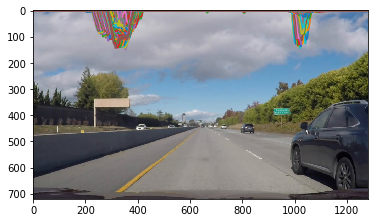

In [57]:

challenge_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")#.subclip(10,11)
challenge_clip = clip1.fl_image(process_video_image) 
challenge_clip.write_videofile(challenge_output, audio=False)

Next is the result of the pipeline on a harder challenge video

In [59]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('challenge_result.mp4'))

### Possible Limitations:
The video pipeline developed in this project did a fairly robust job of detecting the lane lines in the test video provided for the project, which shows a road in basically ideal conditions, with fairly distinct lane lines, and on a clear day. It also did a decent job with the challenge video, although it did lose the lane lines momentarily when there was heavy shadow over the road from an overpass. 

Also due to white squares between the lane histogram changes and so is fitting polynomial which resulted in in some twisted lane filled in challange video. Also during turns algorithm is not very robust.
   